# Song Valence Prediction using Convolutional Neural Network

## Project Description

Our task is to train a model that will **predict the valence of newly released pop songs**. 
Valence describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (happy, cheerful, euphoric), while tracks with low valence sound more negative (sad, depressed, angry).

### Library imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from scipy.signal import get_window

import os
import re
from tqdm import tqdm
from time import time
from datetime import date

#audio preprocessing library
import librosa
import librosa.display
import IPython.display as ipd


#machine learning libraries
import sklearn
from keras import backend as K
import tensorflow as tf

## The Dataset

For this task we will be using the [DEAM dataset](https://cvml.unige.ch/databases/DEAM/). It is publicly available and has been used in many academic research projects. It contains a set of songs from the Free Music Archive with valence annotations made by humans. Every song was evaluated by 10 people, the average score was taken. 

**Valennce is scored from 1-10** we are dealing with a regression problem

In [3]:
#read in the annotations 
df_annotations = pd.read_csv('annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')

In [4]:
df_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.2 KB


In [5]:
df_annotations.head()

,song_id,valence_mean,valence_std,arousal_mean,arousal_std
0,2,3.1,0.94,3.0,0.63
1,3,3.5,1.75,3.3,1.62
2,4,5.7,1.42,5.5,1.63
3,5,4.4,2.01,5.3,1.85
4,7,5.8,1.47,6.4,1.69


In [59]:
df_annotations.columns

Index(['song_id', 'valence_mean', 'valence_std', 'arousal_mean',
       'arousal_std'],
      dtype='object')

In [64]:
df_annotations['file_name2']=df_annotations["song_id"].astype(str) + ".mp3"

In [65]:
meta=pd.read_csv('metadata/metadata_2013.csv')
meta.head()

,song_id,file_name,Artist,Song title,start of the segment (min.sec),end of the segment (min.sec),Genre
0,2,\t2.mp3,The New Mystikal Troubadours\t,\tTonight A Lonely Century\t,0.48,1.33,\tBlues\t
1,3,\t3.mp3,Kevin MacLeod\t,\tDD Groove\t,0.36,1.21,\tBlues\t
2,4,\t4.mp3,Kevin MacLeod\t,\tSlow Burn\t,1.29,2.14,\tBlues\t
3,5,\t5.mp3,My Bubba & Mi\t,\tNothing Much\t,0.36,1.21,\tBlues\t
4,7,\t7.mp3,Kevin MacLeod\t,\tHustle\t,0.20,1.05,\tBlues\t


In [66]:
data = df_annotations.merge(meta, on="song_id",how="outer")
data.sample(5)

,song_id,valence_mean,valence_std,arousal_mean,arousal_std,file_name2,file_name,Artist,Song title,start of the segment (min.sec),end of the segment (min.sec),Genre
591,758,4.8,1.89,5.9,1.04,758.mp3,\t758.mp3,ghostandthesong\t,\tOu Inme\t,0.09,0.54,\tPop\t
554,714,4.4,1.80,4.8,1.78,714.mp3,\t714.mp3,Nature\t,\tIn The Techno Tent\t,7.37,8.22,\tJazz\t
1278,1535,5.4,1.20,5.3,1.10,1535.mp3,NaN,NaN,NaN,NaN,NaN,NaN
519,672,4.4,2.33,6.3,1.73,672.mp3,\t672.mp3,Kevin MacLeod\t,\tVibe Ace\t,0.11,0.56,\tJazz\t
698,934,6.2,1.78,6.4,1.62,934.mp3,\t934.mp3,Lame Drivers\t,\tOther Side\t,0.53,1.38,\tRock\t


## Sample of Song

857.mp3
Sampling rate: 22050
song_id                                                    857
valence_mean                                               4.9
valence_std                                               1.87
arousal_mean                                               5.3
arousal_std                                               1.95
file_name2                                             857.mp3
file_name                                            \t857.mp3
Artist                                  Charlotte Gainsbourg\t
Song title                        \tTrick Pony (Live @ KEXP)\t
start of the segment (min.sec)                            1.23
end of the segment (min.sec)                              2.08
Genre                                                  \tPop\t
Name: 653, dtype: object


/Users/marcelamendoza/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


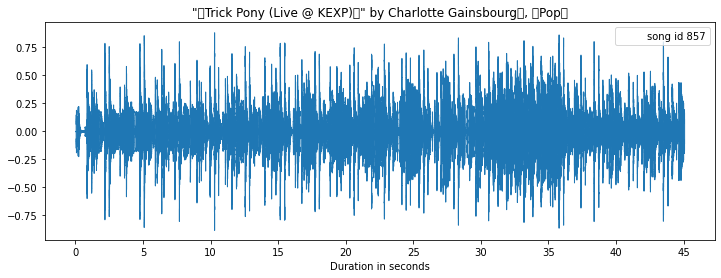

In [188]:
random_idx = np.random.randint(0, 1744)

# select a random song from the dataset
song = data.loc[random_idx, :]

print(song["file_name2"])

# load the file and print its sampling rate 
file_path = "MEMD_audio/" + song["file_name2"]
audio, sample_rate = librosa.load(file_path)
# print info about this song
print(f"Sampling rate: {sample_rate}")
print(song)

# plot the wavefrom
plt.figure(figsize=(12,4))
librosa.display.waveshow(audio, sr=sample_rate) # plot a waveform and play the file
plt.title(f'"{song["Song title"]}" by {song.Artist}, {song.Genre}')
plt.legend([f"song id {song.song_id}"])
plt.xlabel("Duration in seconds")

# output the audio
ipd.Audio(file_path)

# Feature Extraction  - The Melspectrogram

**Melspectrograms** are commonly used in audio Machine Learning as a preprocessing technique.  

Spectrograms are created using a Fourier Transform. In short, Fourier Transforms isolate different sound frequencies that are present in a sound, and resumes them in a strength-per-frequency-matrix, which we call a spectrogram.

In [70]:
y, sr = librosa.load('MEMD_audio/4.mp3', duration=45)

In [71]:
ps = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=90)
ps.shape

/var/folders/dd/w9fvb4q53yl3mvzg47fqvxrr0000gn/T/ipykernel_31647/190911436.py:1: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.3103088  -0.34415892
 -0.39833945] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ps = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=90)


(90, 1938)

<Figure size 1152x864 with 0 Axes>

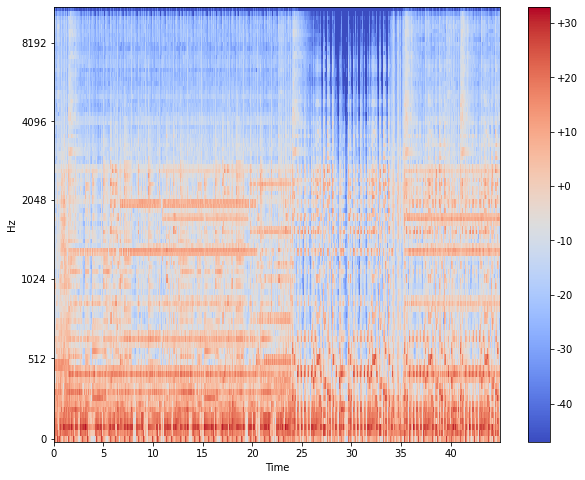

<Figure size 1152x864 with 0 Axes>

In [176]:
ps_log_scale = librosa.power_to_db(ps)
plt.figure(figsize=(10, 8)) 
librosa.display.specshow(ps_log_scale, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format="%+2.f")
plt.figure(figsize=(16, 12)) 

In [189]:
x_test[0]

array([[-48.865677 , -48.865677 , -19.608862 , ...,   7.393777 ,
          8.8989525,   8.372002 ],
       [-48.865677 , -48.865677 , -17.255028 , ...,  15.761628 ,
         16.816187 ,  15.803658 ],
       [-48.865677 , -48.865677 , -17.698864 , ...,  10.54615  ,
         11.854294 ,  11.542802 ],
       ...,
       [-48.865677 , -48.865677 , -48.865677 , ..., -20.02659  ,
        -20.538563 , -24.908531 ],
       [-48.865677 , -48.865677 , -48.865677 , ..., -25.400127 ,
        -25.685238 , -30.674677 ],
       [-48.865677 , -48.865677 , -48.865677 , ..., -44.14133  ,
        -42.14776  , -43.689743 ]], dtype=float32)

In [73]:
def feature_extract(file):
    y, sr = librosa.load(file, duration=44) # max duration is 44
    ms = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=90)
    ms_log = np.array(librosa.power_to_db(ms))
    return ms_log

In [75]:
audio_data_path='MEMD_audio/'
extracted_features = []

for index_n, row in tqdm(data.iterrows()):
    try: 
        file_name = os.path.join(os.path.abspath(audio_data_path), str(row['file_name2']))
        valence_val = row["valence_mean"]
        mels = feature_extract(file_name)
        extracted_features.append([mels, valence_val])
    except: 
        print('no file')


1744it [1:57:04,  4.03s/it]


In [81]:
import pickle 

filename = 'extracted_features'
outfile = open(filename,'wb')

pickle.dump(extracted_features, outfile)
outfile.close()

In [123]:
print(extracted_features[1][0])
print(len(extracted_features))
X=[]
y=[]
for i in range(len(extracted_features)):
    x.append(extracted_features[i][0])
    y.append(extracted_features[i][1])
    

[[-47.780193  -47.780193   -2.7436707 ...  15.065299   15.047678
   14.311939 ]
 [-47.780193  -47.780193   -4.329482  ...  16.536758   16.67042
   16.282618 ]
 [-47.780193  -47.780193  -11.989759  ...  12.968226   12.7733
   12.883919 ]
 ...
 [-47.780193  -47.780193  -47.780193  ... -47.780193  -47.780193
  -47.780193 ]
 [-47.780193  -47.780193  -47.780193  ... -47.780193  -47.780193
  -47.780193 ]
 [-47.780193  -47.780193  -47.780193  ... -47.780193  -47.780193
  -47.780193 ]]
1744


In [130]:
x_array=np.array(X)
y_array=np.array(y)
print(x_array.shape)

(1744, 90, 1895)


## Split into Train and Test set 

In order to train and evalutate our model, we will split the data into train and validation (test) sets. 

In [131]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_array, y_array, test_size=0.2, random_state=42)

## Using Keras CNN model for Regression

We will be using a CNN architecture with 6 convolutional layers.  Since this is a regression problem, we set the last layer to have a linear activation (default).  We also use Mean Squared Error as a loss. 

In [132]:
%%time
from tensorflow.random import set_seed
with tf.device('/gpu:0'):
    set_seed(64)
    # Set up the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(90, 1895, 1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128, activation="relu"))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1)) 

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Fit the model
    model.fit(x_train, y_train, epochs=46, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/46
6/6 [==============================] - 114s 18s/step - loss: 104.8314 - mae: 7.5256 - val_loss: 17.1944 - val_mae: 3.9567
Epoch 2/46
6/6 [==============================] - 99s 16s/step - loss: 11.4423 - mae: 2.8799 - val_loss: 4.1275 - val_mae: 1.7038
Epoch 3/46
6/6 [==============================] - 89s 14s/step - loss: 6.7643 - mae: 2.2636 - val_loss: 2.6273 - val_mae: 1.3504
Epoch 4/46
6/6 [==============================] - 84s 13s/step - loss: 3.2066 - mae: 1.4160 - val_loss: 2.3534 - val_mae: 1.2714
Epoch 5/46
6/6 [==============================] - 86s 14s/step - loss: 2.4454 - mae: 1.2810 - val_loss: 2.3317 - val_mae: 1.2260
Epoch 6/46
6/6 [==============================] - 82s 13s/step - loss: 2.0716 - mae: 1.1597 - val_loss: 1.9186 - val_mae: 1.1324
Epoch 7/46
6/6 [==============================] - 84s 14s/step - loss: 1.8515 - mae: 1.0999 - val_loss: 1.7635 - val_mae: 1.0747
Epoch 8/46
6/6 [==============================] - 86s 14s/step - loss: 1.6855 - mae: 1.0552 

We are doing well on the validation set with a final mae of .6480 .  Let's look at what our individual predictions look like! 

## Evaluating the Model 

11/11 [==============================] - 4s 387ms/step
R2 score is 0.5329872035031062


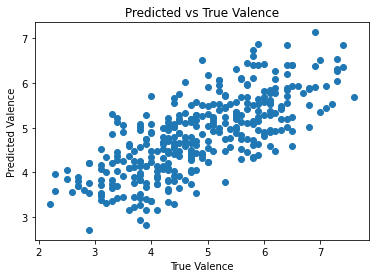

In [171]:
y_pred=model.predict(x_test)
plt.scatter(y_test, y_pred)
plt.xlabel("True Valence")
plt.ylabel("Predicted Valence")
plt.title("Predicted vs True Valence")
#fit r2 
r2_score=sklearn.metrics.r2_score(y_test, y_pred)
print(f'R2 score is {r2_score}')


## DEMO

In [142]:
#get indices of test and train data for Demo
n_samples= len(x_array)
print(n_samples)
indices=np.arange(n_samples)
x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x_array, y_array, indices, test_size=0.2, random_state=42)

1744


In [190]:
sad_song_index =np.where(y_test<=3)[0][0]  #find a song annotated as sad
happy_song_index= np.where(y_test>=7)[0][2] #find a song annotated by happy

demo_index=happy_song_index
data_index=indices_test[demo_index]
print(demo_index)
print(f'Predicted valence is: {y_pred[demo_index][0]}')
print(f' True valences is: {y_test[demo_index]}\n')


song = data.loc[data_index,:]
print(song)
file_path = "MEMD_audio/" + song["file_name2"]
ipd.Audio(file_path)

115
Predicted valence is: 6.363332748413086
 True valences is: 7.4

song_id                                                        629
valence_mean                                                   7.4
valence_std                                                   0.92
arousal_mean                                                   7.6
arousal_std                                                    0.8
file_name2                                                 629.mp3
file_name                                                \t629.mp3
Artist                            Goto80 and the Uwe Schenk Band\t
Song title                               \tVolksing Ferretismico\t
start of the segment (min.sec)                                 1.3
end of the segment (min.sec)                                  2.15
Genre                                                     \tJazz\t
Name: 485, dtype: object
